## Setup

**Note**: Use TensorFlow 2.10 to run this. Versions above TensorFlow 2.10 may not run successfully.

In [ ]:
!pip install remotezip tqdm opencv-python einops
!pip install tensorflow==2.10.0

^C


^C
  Using cached tensorflow-2.10.0-cp39-cp39-win_amd64.whl (455.9 MB)


In [1]:
import pathlib

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import random

## Load and preprocess video data

In [2]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [3]:
import random
from collections import Counter

class FrameGenerator:
    def __init__(self, path, n_frames, training=False, oversample=True):
        """ Returns a set of frames with their associated label.

        Args:
          path: Video file paths.
          n_frames: Number of frames.
          training: Boolean to determine if the training dataset is being created.
          oversample: Boolean to determine if oversampling should be applied.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.oversample = oversample
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def oversample_data(self, pairs):
      counter = Counter(pair[1] for pair in pairs)
      max_class_count = max(counter.values())

      oversampled_pairs = []
      for class_name, count in counter.items():
          class_samples = [pair for pair in pairs if pair[1] == class_name]
          oversampled_pairs.extend(random.choices(class_samples, k=max_class_count))

      return oversampled_pairs

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.oversample and self.training:
            pairs = self.oversample_data(pairs)
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [4]:
# Specify the paths to your train, val, and test folders
subset_paths = {
    'train': './Indian_shoplifting/train',
    'val': './Indian_shoplifting/val',
    'test': './Indian_shoplifting/test'
}

n_frames = 10
batch_size = 8

output_signature = (
    tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)

train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(pathlib.Path(subset_paths['train']), n_frames, training=True, oversample=True),
    output_signature=output_signature
)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(pathlib.Path(subset_paths['val']), n_frames),
    output_signature=output_signature
)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(pathlib.Path(subset_paths['test']), n_frames),
    output_signature=output_signature
)

test_ds = test_ds.batch(batch_size)

## Create the model

In [5]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [6]:
from tensorflow.keras import layers, models, regularizers

def InceptionModule(x, filters):
    max_filters = 128
    branch1x1 = layers.Conv3D(min(filters[0], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    branch1x1 = layers.BatchNormalization()(branch1x1)

    branch3x3 = layers.Conv3D(min(filters[1], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    branch3x3 = layers.Conv3D(min(filters[2], max_filters), (3, 3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(branch3x3)

    branch5x5 = layers.Conv3D(min(filters[3], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    branch5x5 = layers.Conv3D(min(filters[4], max_filters), (5, 5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch5x5)
    
    branch_pool = layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    branch_pool = layers.Conv3D(min(filters[5], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(branch_pool)

    return layers.concatenate([branch1x1, branch3x3,branch5x5, branch_pool], axis=-1)

def InceptionI3D(input_shape=(10, 224, 224, 3), num_classes=10):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv3D(min(64, 128), (7, 7, 7), strides=(2, 2, 2), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same')(x)
    x = layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same')(x)

    x = InceptionModule(x, [min(64, 128), min(128, 128), min(128, 128), min(128, 128), min(192, 128), min(32, 128)])
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    x = InceptionModule(x, [min(192, 128), min(96, 128), min(208, 128), min(16, 128), min(48, 128), min(64, 128)])
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = layers.GlobalAveragePooling3D()(x)

    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

    model = models.Model(inputs=input_layer, outputs=x)

    return model

In [7]:
input_shape = ( 10, HEIGHT, WIDTH, 3)
model = InceptionI3D(input_shape=input_shape, num_classes=2)

In [8]:
frames, label = next(iter(train_ds))
model.build(frames)

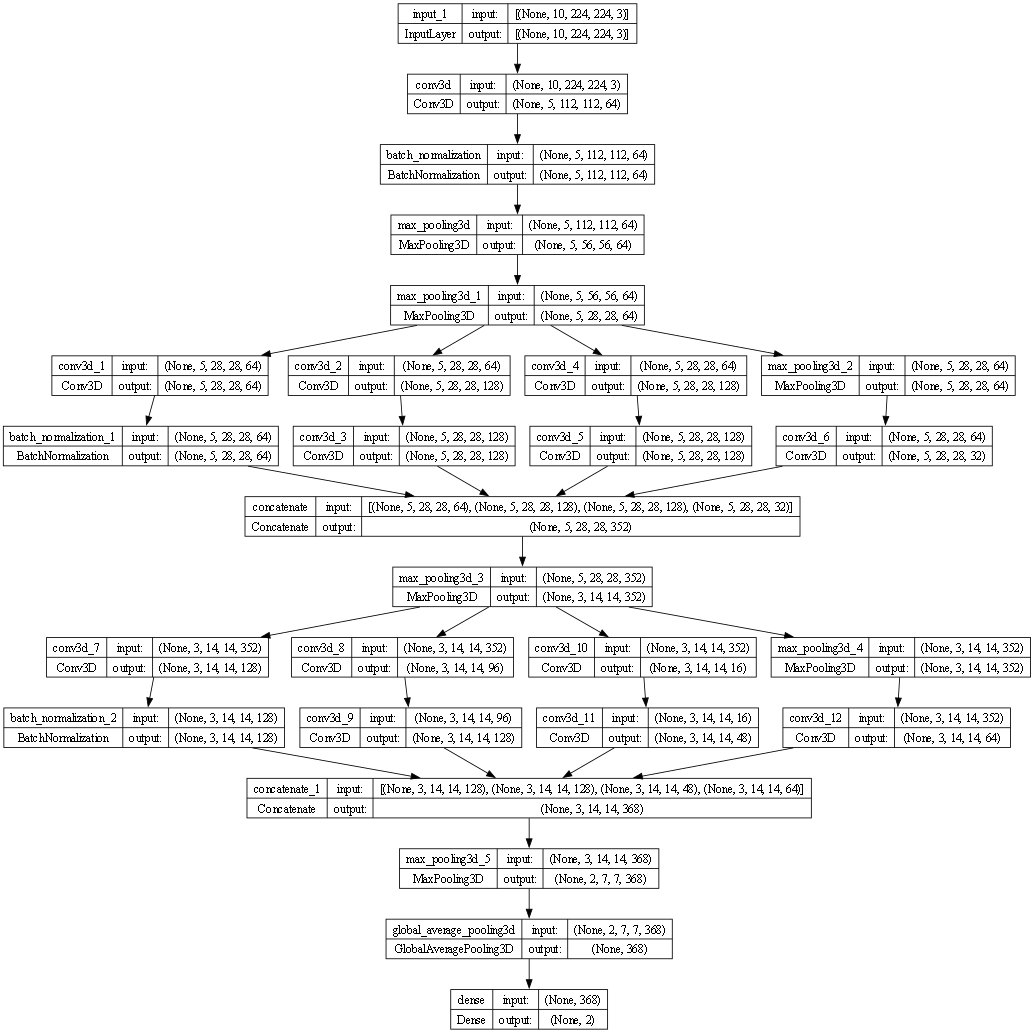

In [9]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 5, 112, 112,  65920       ['input_1[0][0]']                
                                 64)                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 112, 112,  256        ['conv3d[0][0]']                 
 alization)                      64)                                                          

## Train the model

In [11]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [12]:
# Count the occurrences of each class in the training dataset
class_counts = Counter(label.numpy() for _, label in train_ds.unbatch())

# Calculate weights based on the inverse of class frequencies
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

# Manually set a higher weight for the "Shoplifting" class
shoplifting_class_weight = 2.0
class_weights[1] = shoplifting_class_weight  # Assuming the index for "Shoplifting" is 1

# Use the class_weights in the fit function
history = model.fit(
    x=train_ds,
    epochs=60,
    validation_data=val_ds,
    class_weight=class_weights
)

Epoch 1/60
22/22 [==============================] - 78s 3s/step - loss: 4.2651 - accuracy: 0.7356 - val_loss: 4.1139 - val_accuracy: 0.6400
Epoch 2/60
22/22 [==============================] - 65s 3s/step - loss: 3.9612 - accuracy: 0.8276 - val_loss: 3.9964 - val_accuracy: 0.8400
Epoch 3/60
22/22 [==============================] - 65s 3s/step - loss: 3.7804 - accuracy: 0.8333 - val_loss: 3.8625 - val_accuracy: 0.6000
Epoch 4/60
22/22 [==============================] - 66s 3s/step - loss: 3.7046 - accuracy: 0.8276 - val_loss: 3.7901 - val_accuracy: 0.6000
Epoch 5/60
22/22 [==============================] - 61s 3s/step - loss: 3.5114 - accuracy: 0.8851 - val_loss: 3.6468 - val_accuracy: 0.6000
Epoch 6/60
22/22 [==============================] - 63s 3s/step - loss: 3.4901 - accuracy: 0.7931 - val_loss: 3.5372 - val_accuracy: 0.6000
Epoch 7/60
22/22 [==============================] - 62s 3s/step - loss: 3.2108 - accuracy: 0.9195 - val_loss: 3.5099 - val_accuracy: 0.6000
Epoch 8/60
22/22 [==

In [ ]:
model.evaluate(test_ds, return_dict=True)

3/3 [==============================] - 5s 1s/step - loss: 1.6212 - accuracy: 0.9167


{'loss': 1.6211707592010498, 'accuracy': 0.9166666865348816}

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

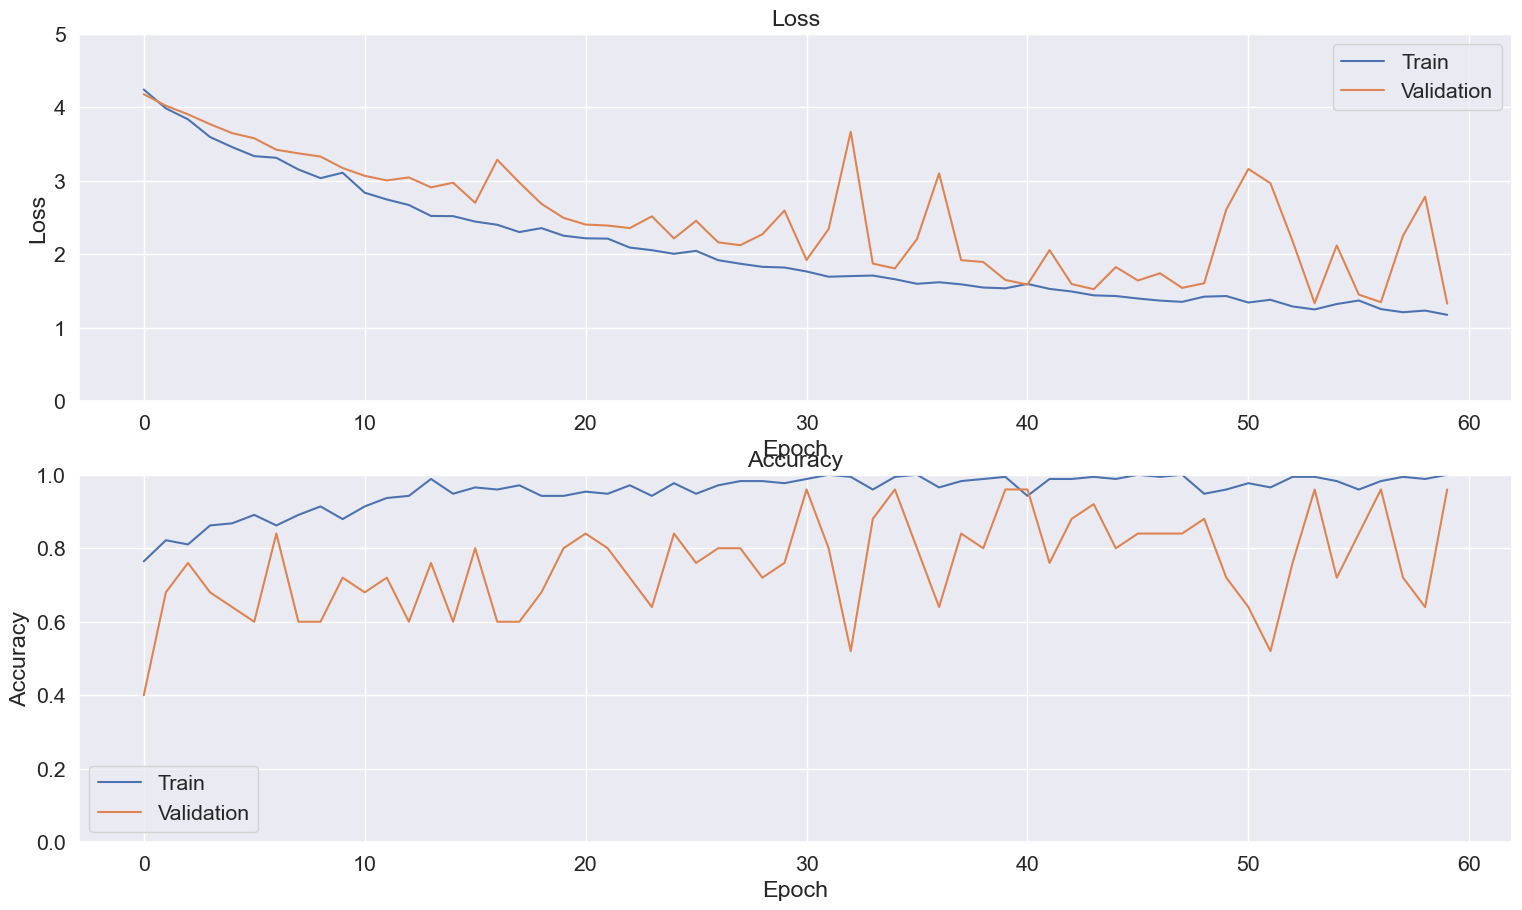

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

In [ ]:
model.evaluate(test_ds, return_dict=True)

3/3 [==============================] - 5s 1s/step - loss: 1.6274 - accuracy: 0.9167


{'loss': 1.6274254322052002, 'accuracy': 0.9166666865348816}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [ ]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(pathlib.Path(subset_paths['train']), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

22/22 [==============================] - 30s 1s/step


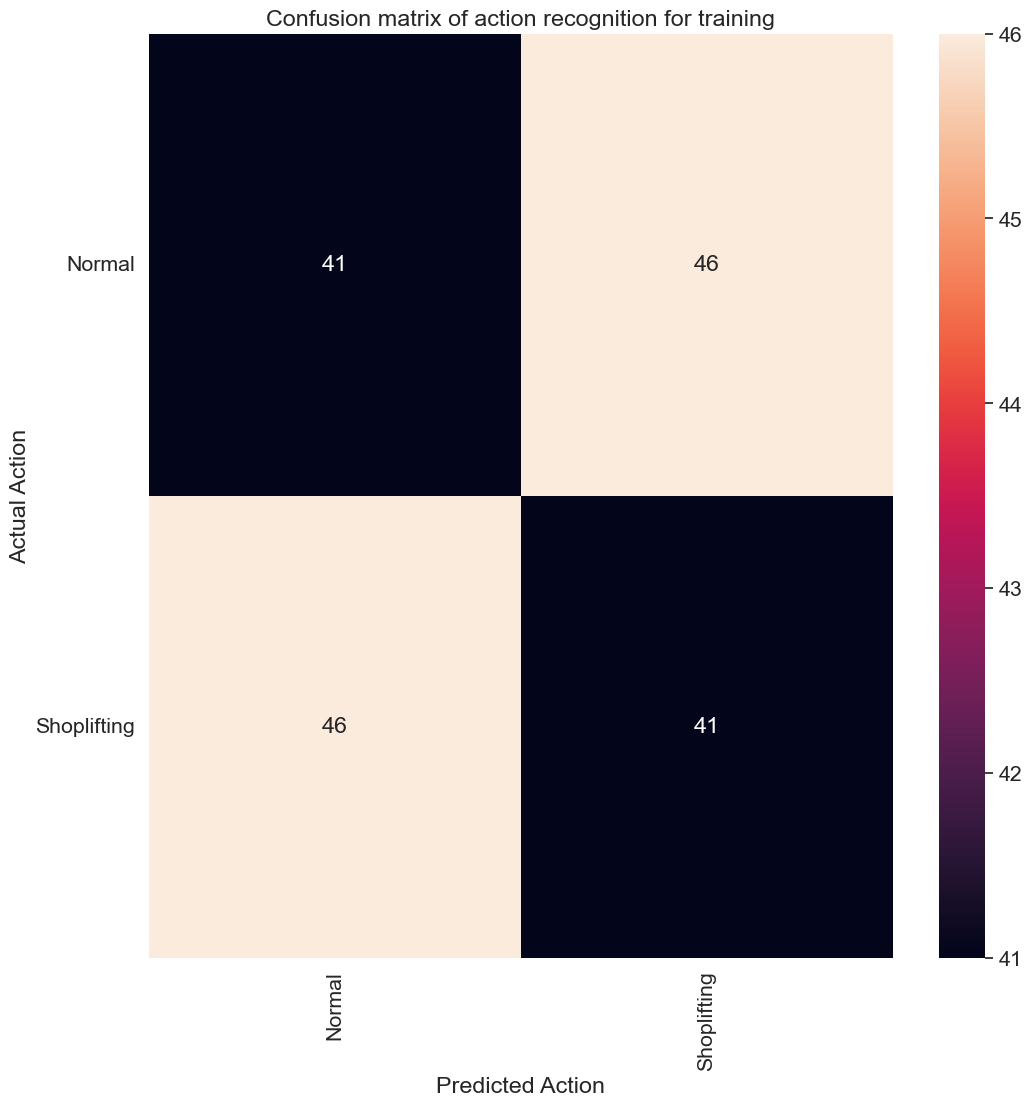

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

3/3 [==============================] - 5s 2s/step


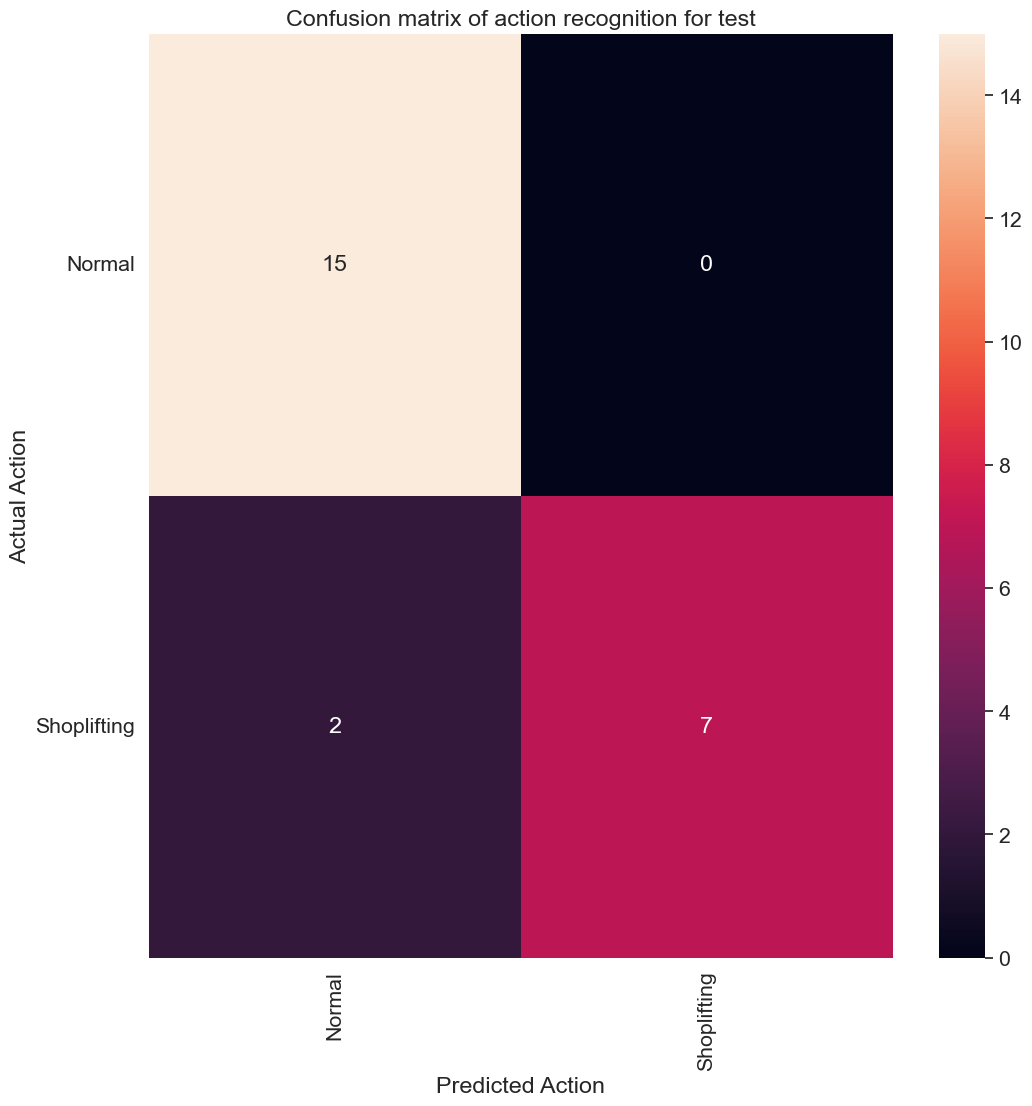

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

{'Normal': 0.8823529411764706, 'Shoplifting': 1.0}

In [ ]:
recall

{'Normal': 1.0, 'Shoplifting': 0.7777777777777778}

# Test Analysis

In [ ]:
import cv2
import numpy as np

def load_and_preprocess_video(video_path, target_shape=(224, 224), num_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to target shape
        frame = cv2.resize(frame, target_shape)
        # Normalize pixel values to the range [0, 1]
        frame = frame / 255.0

        frames.append(frame)

    cap.release()

    # Pad or truncate frames to have the desired number of frames (num_frames)
    frames = frames[:num_frames] + [np.zeros_like(frames[0])] * (num_frames - len(frames))

    return np.array(frames)

# Usage
video_path = 'videoplayback.mp4'
frames = load_and_preprocess_video(video_path, target_shape=(224, 224), num_frames=10)
frames = frames[np.newaxis, ...]  # Add batch dimension
predictions = model(frames)
print(predictions)
predicted_class = np.argmax(predictions)
print(f"The predicted class for the video is: {predicted_class}")

# Real-time Analysis

### Instant

In [27]:
frame_buffer = []
# Define constants
HEIGHT = 224
WIDTH = 224
NUM_FRAMES = 10
# Define the preprocess_frame function
def preprocess_frame(frame):
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = frame / 255.0  # Normalize pixel values to be between 0 and 1
    return frame

# Define the predict_action function
def predict_action(frames):
    # Assuming frames is a list of 10 frames
    preprocessed_frames = [preprocess_frame(frame) for frame in frames]
    expanded_frames = np.expand_dims(preprocessed_frames, axis=0)
    predictions = model.predict(expanded_frames)
    action_label = np.argmax(predictions)
    return action_label

In [28]:
# Open the video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Add the frame to the buffer
    frame_buffer.append(preprocessed_frame)

    # Keep the buffer size to NUM_FRAMES
    if len(frame_buffer) == NUM_FRAMES:
        # Make prediction using the buffered frames
        action_label = predict_action(frame_buffer)

        # Do something with the predicted action label q(print, display, etc.)
        print("Predicted Action:", action_label)

        # Display the frame if needed
        cv2.imshow('Frame', frame)

        # Remove the oldest frame from the buffer
        frame_buffer.pop(0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 638ms/step
Predicted Action: 0
1/1 [==============================] - 0s 35ms/step
Predicted Action: 0
1/1 [==============================] - 0s 38ms/step
Predicted Action: 0
1/1 [==============================] - 0s 39ms/step
Predicted Action: 0
1/1 [==============================] - 0s 39ms/step
Predicted Action: 0
1/1 [==============================] - 0s 29ms/step
Predicted Action: 0
1/1 [==============================] - 0s 28ms/step
Predicted Action: 0
1/1 [==============================] - 0s 37ms/step
Predicted Action: 0
1/1 [==============================] - 0s 43ms/step
Predicted Action: 0
1/1 [==============================] - 0s 30ms/step
Predicted Action: 0
1/1 [==============================] - 0s 30ms/step
Predicted Action: 0
1/1 [==============================] - 0s 32ms/step
Predicted Action: 0
1/1 [==============================] - 0s 35ms/step
Predicted Action: 0
1/1 [==============================] - 0s 53ms/step
Predicted A